## 콘크리트 압축강도 예측 : 데이터 분석, 시각화 및 모델링

In [1]:
%autosave 0

Autosave disabled


In [2]:
# 라이브러리 호출
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

from sklearn.decomposition import PCA
from pca import pca

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [3]:
df = pd.read_csv('data/Concrete_Data.csv')

In [4]:
df.head()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


In [5]:
df.isna().sum() # 결측값 확인

Cement (component 1)(kg in a m^3 mixture)                0
Blast Furnace Slag (component 2)(kg in a m^3 mixture)    0
Fly Ash (component 3)(kg in a m^3 mixture)               0
Water  (component 4)(kg in a m^3 mixture)                0
Superplasticizer (component 5)(kg in a m^3 mixture)      0
Coarse Aggregate  (component 6)(kg in a m^3 mixture)     0
Fine Aggregate (component 7)(kg in a m^3 mixture)        0
Age (day)                                                0
Concrete compressive strength(MPa, megapascals)          0
dtype: int64

In [6]:
# 컬럼명 변경
features = ['cement', 'blast furnace slag', 'fly ash', 'water', 'superlasticizer', 'coarse aggregate', 'fine aggregate', 'age', 'str']
df.columns = features

In [7]:
df.head()

,cement,blast furnace slag,fly ash,water,superlasticizer,coarse aggregate,fine aggregate,age,str
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


## 새로운 컬럼 추가 및 삭제 df2로 정의

In [8]:
Mixed_fire = df.iloc[:,1] + df.iloc[:,2] + df.iloc[:,4]
aggregate = df.iloc[:,5] + df.iloc[:,6]

In [9]:
df2 = df.drop('fly ash' , axis = 1)
df2 = df2.drop('blast furnace slag', axis = 1)
df2 = df2.drop('superlasticizer', axis = 1)
df2 = df2.drop('coarse aggregate', axis = 1)
df2 = df2.drop('fine aggregate', axis = 1)
df2 = df2.drop('str', axis =1)

In [10]:
df2['Mixed_fire'] = Mixed_fire
df2['Aggregate '] = aggregate/2
df2['str'] = df.iloc[:,8]

In [11]:
df2.head()

,cement,water,age,Mixed_fire,Aggregate,str
0,540.0,162.0,28,2.5,858.00,79.986111
1,540.0,162.0,28,2.5,865.50,61.887366
2,332.5,228.0,270,142.5,763.00,40.269535
3,332.5,228.0,365,142.5,763.00,41.052780
4,198.6,192.0,360,132.4,901.95,44.296075


In [12]:
# 사분위수 분할
IQR = df2['str'].quantile(0.75) - df2['str'].quantile(0.25)
cut_high = df2['str'].quantile(0.75) + IQR*1.5
cut_low = df2['str'].quantile(0.25) - IQR*1.5

In [13]:
# 사분위수 명칭
def get_cat(x):
    result = 0
    
    if cut_low <= x < df2['str'].quantile(0.25):
        result = 0
    elif df2['str'].quantile(0.25) <= x < df2['str'].quantile(0.5):
        result=1
    elif df2['str'].quantile(0.5) <= x < df2['str'].quantile(0.75) :
        result=2
    else:
        result=3
    
    return result

In [14]:
df2['str_grp'] = df2['str'].apply(lambda x: get_cat(x))

In [15]:
df2.head()

,cement,water,age,Mixed_fire,Aggregate,str,str_grp
0,540.0,162.0,28,2.5,858.00,79.986111,3
1,540.0,162.0,28,2.5,865.50,61.887366,3
2,332.5,228.0,270,142.5,763.00,40.269535,2
3,332.5,228.0,365,142.5,763.00,41.052780,2
4,198.6,192.0,360,132.4,901.95,44.296075,2


In [16]:
X = df2.iloc[:,:5]
y1 = df2.iloc[:,5]
y2 = df2.iloc[:,6]

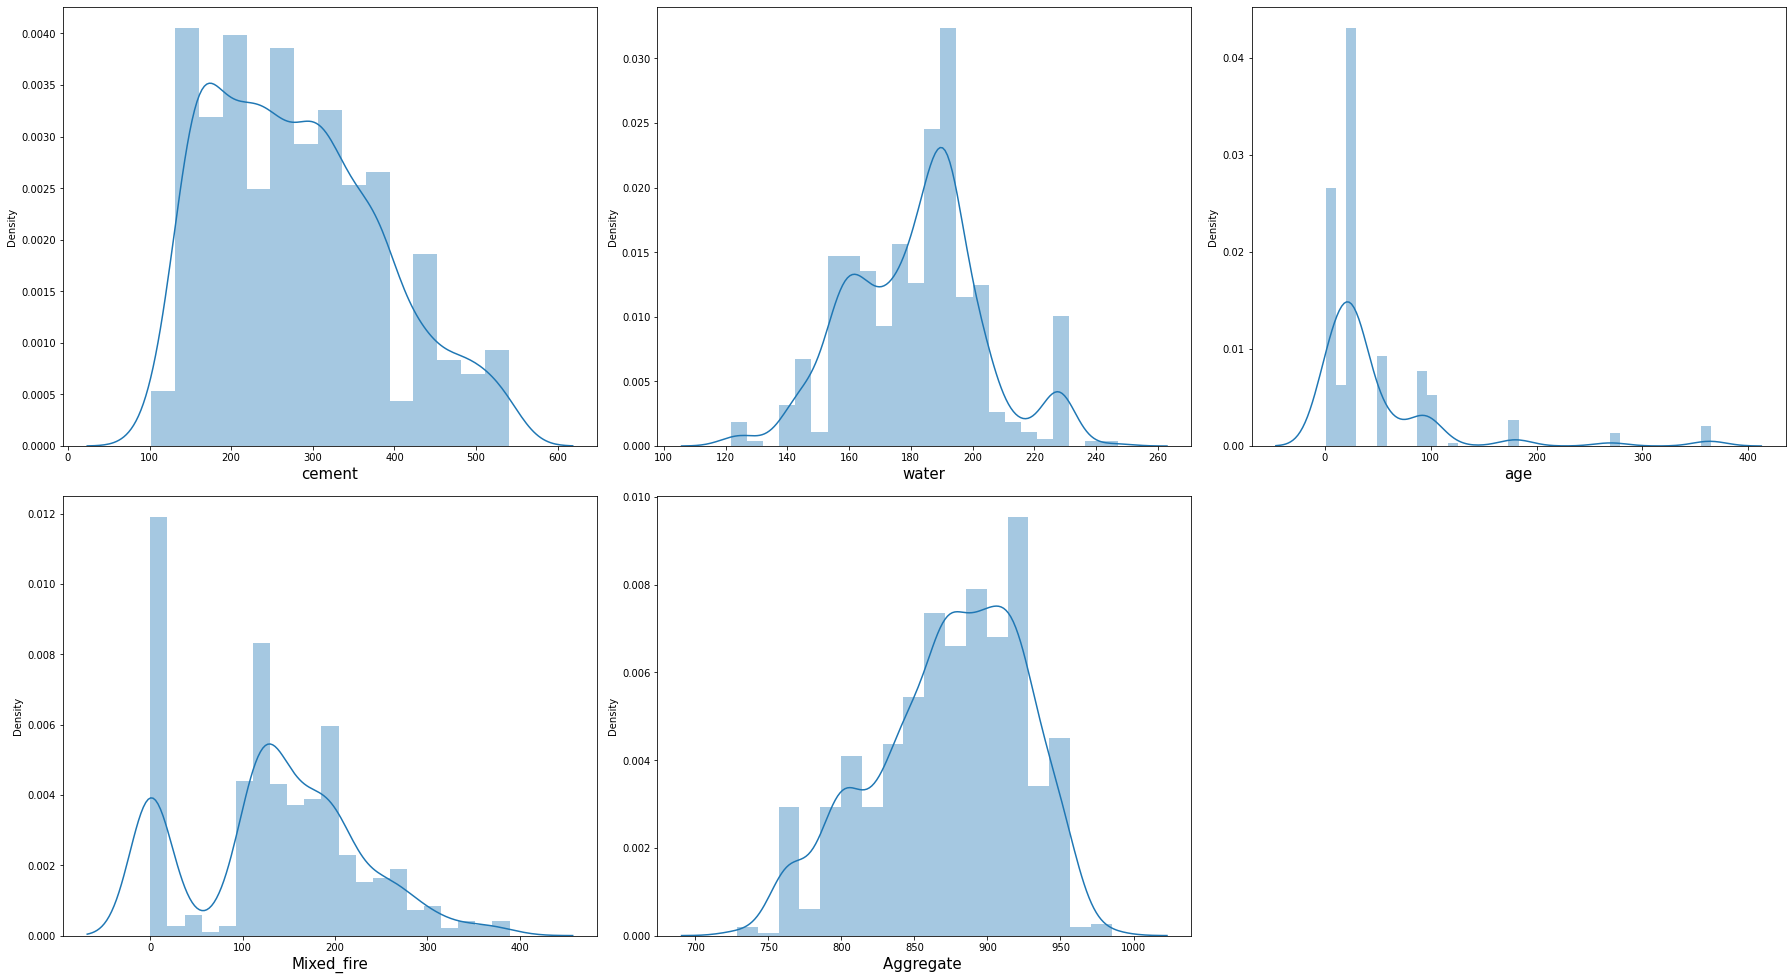

In [17]:
plt.figure(figsize = (25, 20))
plotnumber = 1

for col in X.columns:
    if plotnumber <= 8:
        ax = plt.subplot(3, 3, plotnumber)
        sns.distplot(X[col])
        plt.xlabel(col, fontsize = 15)
        
    plotnumber += 1
    
plt.tight_layout()
plt.show()

In [18]:
X = df2.iloc[:,:5]
y = df2.iloc[:,5]

In [19]:
label = ['cement','water','age', 'Mixed_fire', 'Aggregate','str','str_grp']

## 결론 : 표준화를 해서 값을 봐도 결국엔 같음

* 데이터가 정규화되고 모양이 좋으므로 특이치가 있는지 확인

In [20]:
df2.head()

,cement,water,age,Mixed_fire,Aggregate,str,str_grp
0,540.0,162.0,28,2.5,858.00,79.986111,3
1,540.0,162.0,28,2.5,865.50,61.887366,3
2,332.5,228.0,270,142.5,763.00,40.269535,2
3,332.5,228.0,365,142.5,763.00,41.052780,2
4,198.6,192.0,360,132.4,901.95,44.296075,2


In [21]:
df2 = round(df2,2)

In [22]:
df2.head()

,cement,water,age,Mixed_fire,Aggregate,str,str_grp
0,540.0,162.0,28,2.5,858.00,79.99,3
1,540.0,162.0,28,2.5,865.50,61.89,3
2,332.5,228.0,270,142.5,763.00,40.27,2
3,332.5,228.0,365,142.5,763.00,41.05,2
4,198.6,192.0,360,132.4,901.95,44.30,2


In [23]:
df2.to_csv('Concrete_Data_2.csv',index=None, encoding='euc-kr')

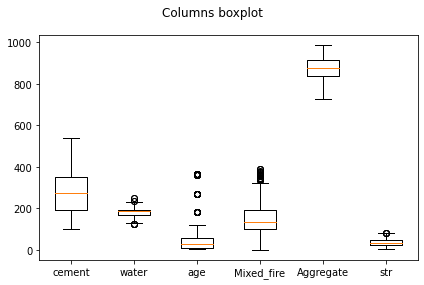

In [24]:
fig, axes = plt.subplots(1,1)
fig.suptitle('Columns boxplot')
axes.set_xticklabels(label)
axes.boxplot(df2.iloc[:,:6])
plt.tight_layout()
plt.show()

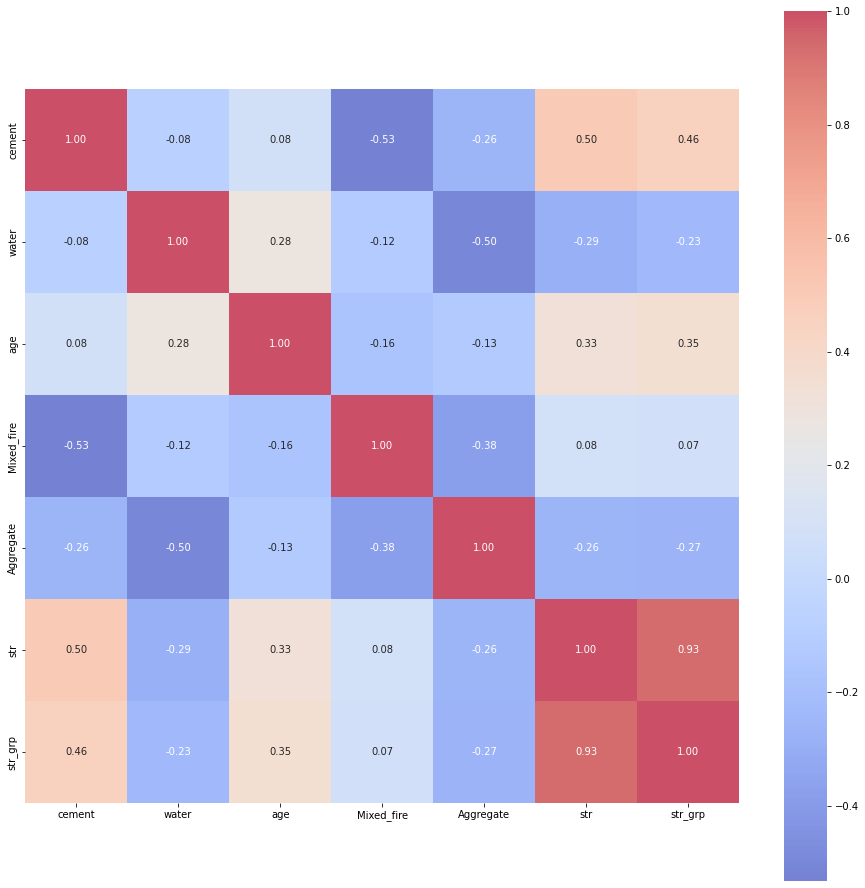

In [25]:
# heatmap을 사용해서 상관관계 확인하기
corr = df2.corr()
plt.figure(figsize=(16,16))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 10},
           xticklabels= label, yticklabels= label, alpha = 0.7,   cmap= 'coolwarm')
plt.show()

In [26]:
# 데이터 분할하기(강도)
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y1, test_size = 0.25)

In [27]:
# 데이터 분할하기(강도그룹화)
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y2, test_size = 0.25)

In [28]:
# 데이터 스케일링
sc = StandardScaler()
X1_train = sc.fit_transform(X1_train)
X1_test = sc.transform(X1_test)
X2_train = sc.fit_transform(X2_train)
X2_test = sc.transform(X2_test) 

In [29]:
y1

0       79.986111
1       61.887366
2       40.269535
3       41.052780
4       44.296075
          ...    
1025    44.284354
1026    31.178794
1027    23.696601
1028    32.768036
1029    32.401235
Name: str, Length: 1030, dtype: float64

In [30]:
y2

0       3
1       3
2       2
3       2
4       2
       ..
1025    2
1026    1
1027    0
1028    1
1029    1
Name: str_grp, Length: 1030, dtype: int64

## 선형 회귀분석

In [31]:
lr1 = LinearRegression()
lr1.fit(X1_train, y1_train)

LinearRegression()

In [32]:
lr1.score(X1_train, y1_train)

0.6108842018874497

In [33]:
lr1.score(X1_test, y1_test)

0.611312115316123

In [34]:
lr2 = LinearRegression()
lr2.fit(X2_train, y2_train)

LinearRegression()

In [35]:
lr2.score(X2_train, y2_train)

0.549817740768447

In [36]:
lr2.score(X2_test, y2_test)

0.5104340149312183

## 로지스틱 회귀분석

In [37]:
features = df2.iloc[:,:5]
target = df2.iloc[:,6]

In [38]:
# 데이터 분할하기(강도그룹화)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.25)

In [39]:
#스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [40]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [41]:
print(model.score(X_train, y_train))

0.6450777202072538


In [67]:
print(model.coef_)

[[-2.21502129  0.56303278 -5.17227843 -1.36024882  0.03789602]
 [-0.32577869  0.36840134  0.46266147 -0.19454598  0.05835081]
 [ 0.57511317 -0.25312673  2.12711812  0.15880705 -0.28764766]
 [ 1.96568681 -0.67830739  2.58249884  1.39598775  0.19140083]]


## 의사결정 나무

In [42]:
dtr1 = DecisionTreeRegressor()
dtr1.fit(X1_train, y1_train)

DecisionTreeRegressor()

In [43]:
dtr1.score(X1_train, y1_train)

0.9964916739061093

In [44]:
dtr1.score(X1_test, y1_test)

0.8391984401806132

In [45]:
# 하이퍼 파라미터 조정 
grid_params = {
    'criterion' : ['mse', 'friedman_mse', 'mae'],
    'splitter' : ['best', 'random'],
    'max_depth' : [3, 5, 7, 9, 10],
    'min_samples_split' : [1, 2, 3, 4, 5],
    'min_samples_leaf' : [1, 2, 3, 4, 5]
}

grid_search = GridSearchCV(dtr1, grid_params, cv = 5, n_jobs = -1, verbose = 1)
grid_search.fit(X1_train, y1_train)

Fitting 5 folds for each of 750 candidates, totalling 3750 fits


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'criterion': ['mse', 'friedman_mse', 'mae'],
                         'max_depth': [3, 5, 7, 9, 10],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_samples_split': [1, 2, 3, 4, 5],
                         'splitter': ['best', 'random']},
             verbose=1)

In [46]:
# 최적의 파라미터 확인
print(grid_search.best_params_)
print(grid_search.best_score_)

{'criterion': 'friedman_mse', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 3, 'splitter': 'best'}
0.7925352351891218


In [47]:
dtr1 = DecisionTreeRegressor(criterion = 'friedman_mse', max_depth = 9, min_samples_leaf = 1, min_samples_split = 3, splitter = 'random')
dtr1.fit(X1_train, y1_train)

DecisionTreeRegressor(criterion='friedman_mse', max_depth=9,
                      min_samples_split=3, splitter='random')

In [48]:
dtr1.score(X1_train, y1_train)

0.9125455944704375

In [49]:
dtr1.score(X1_test, y1_test)

0.7677750712302166

In [50]:
dtr2 = DecisionTreeRegressor()
dtr2.fit(X2_train, y2_train)

DecisionTreeRegressor()

In [51]:
dtr2.score(X2_train, y2_train)

0.9920180158305573

In [52]:
dtr2.score(X2_test, y2_test)

0.7054758657639667

In [53]:
# 하이퍼 파라미터 조정 
grid_params = {
    'criterion' : ['mse', 'friedman_mse', 'mae'],
    'splitter' : ['best', 'random'],
    'max_depth' : [3, 5, 7, 9, 10],
    'min_samples_split' : [1, 2, 3, 4, 5],
    'min_samples_leaf' : [1, 2, 3, 4, 5]
}

grid_search = GridSearchCV(dtr2, grid_params, cv = 5, n_jobs = -1, verbose = 1)
grid_search.fit(X2_train, y2_train)

Fitting 5 folds for each of 750 candidates, totalling 3750 fits


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'criterion': ['mse', 'friedman_mse', 'mae'],
                         'max_depth': [3, 5, 7, 9, 10],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_samples_split': [1, 2, 3, 4, 5],
                         'splitter': ['best', 'random']},
             verbose=1)

In [54]:
# 최적의 파라미터 확인
print(grid_search.best_params_)
print(grid_search.best_score_)

{'criterion': 'friedman_mse', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'splitter': 'best'}
0.7614189339805428


In [55]:
dtr2 = DecisionTreeRegressor(criterion = 'friedman_mse', max_depth = 10, min_samples_leaf = 4, min_samples_split = 2, splitter = 'random')
dtr2.fit(X2_train, y2_train)

DecisionTreeRegressor(criterion='friedman_mse', max_depth=10,
                      min_samples_leaf=4, splitter='random')

In [56]:
dtr2.score(X2_train, y2_train)

0.8196954704237582

In [57]:
dtr2.score(X2_test, y2_test)

0.7015095101413116

## 랜덤포레스트 회귀분석

In [58]:
rfr1 = RandomForestRegressor()
rfr1.fit(X1_train, y1_train)

RandomForestRegressor()

In [59]:
rfr1.score(X1_train, y1_train)

0.9819216743176244

In [60]:
rfr1.score(X1_test, y1_test)

0.9030840931395788

In [61]:
rfr2 = RandomForestRegressor()
rfr2.fit(X2_train, y2_train)

RandomForestRegressor()

In [62]:
rfr2.score(X2_train, y2_train)

0.9734094502399816

In [63]:
rfr2.score(X2_test, y2_test)

0.8233838577221827

# 최종 평가

In [64]:
# 각각의 분석 모델을 dataframe으로 만들고 최적의 모델 확인하기
models = pd.DataFrame({
    'Model' : ['Linear Regression(str)', 'Linear Regression(str_grp)', 
               'Decision Tree(str)', 'Decision Tree(str_grp)', 
               'Random Forest(str)','Random Forest(str_grp)'],
    'Score' : [lr1.score(X1_test, y1_test), 
               lr2.score(X2_test, y2_test),
               dtr1.score(X1_test, y1_test),
               dtr2.score(X2_test, y2_test),
               rfr1.score(X1_test, y1_test),
               rfr2.score(X2_test, y2_test),
              ]
})
models.sort_values(by = 'Score', ascending = False)

,Model,Score
4,Random Forest(str),0.903084
5,Random Forest(str_grp),0.823384
2,Decision Tree(str),0.767775
3,Decision Tree(str_grp),0.701510
0,Linear Regression(str),0.611312
1,Linear Regression(str_grp),0.510434


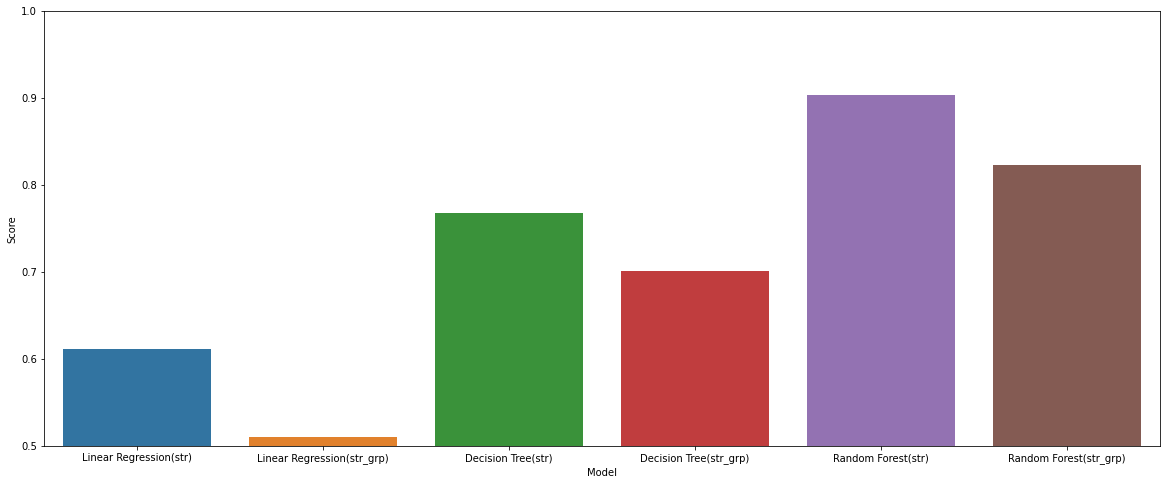

In [65]:
plt.figure(figsize = (20, 8))

sns.barplot(x = 'Model', y = 'Score', data = models)
plt.ylim(0.50, 1)
plt.show()